In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm # 用于颜色映射
import matplotlib.colors as mcolors # 用于颜色映射


In [2]:
def replicator_dynamics(state, t, params):
    """
    三方演化博弈的复制动态方程。

    Args:
        state (tuple): 当前时刻 (t) 的策略比例 (x, y, z)。
                       x: 政府选择“建立认证体系”的比例
                       y: 科创企业选择“实质性创新”的比例
                       z: 投资机构选择“长期投资”的比例
        t (float): 当前时间。
        params (dict): 包含所有模型参数的字典。

    Returns:
        list: 策略比例随时间的变化率 [dx/dt, dy/dt, dz/dt]。
    """
    x, y, z = state

    # 从参数字典中提取参数
    C_G = params['C_G']
    S_G = params['S_G']
    F_E = params['F_E']
    F_I = params['F_I']
    R_H = params['R_H']
    R_L = params['R_L']
    R_O = params['R_O']
    B_E = params['B_E']
    C_certE = params['C_certE']
    P_H = params['P_H']
    P_L = params['P_L']
    P_O = params['P_O']
    B_I = params['B_I']
    C_certI = params['C_certI']

    # 计算期望收益 (参考文档中的公式)
    # 政府期望收益
    U_G1 = y * z * (S_G + F_E + F_I - C_G) + y * (1 - z) * (F_E - C_G) + \
           (1 - y) * z * (F_I - C_G) + (1 - y) * (1 - z) * (-C_G)
    U_G0 = 0 # 政府不建立认证体系时的收益

    # 科创企业期望收益
    U_E1 = x * z * (R_H + B_E - C_certE) + x * (1 - z) * (R_L + B_E - C_certE) + \
           (1 - x) * z * R_H + (1 - x) * (1 - z) * R_L
    U_E0 = R_O # 企业策略性创新的收益

    # 投资机构期望收益
    U_I1 = x * y * (P_H + B_I - C_certI) + x * (1 - y) * (P_O - C_certI) + \
           (1 - x) * y * P_L + (1 - x) * (1 - y) * P_O
    U_I0 = P_O # 投资机构短期投资的收益

    # 计算平均期望收益
    U_G_avg = x * U_G1 + (1 - x) * U_G0
    U_E_avg = y * U_E1 + (1 - y) * U_E0
    U_I_avg = z * U_I1 + (1 - z) * U_I0

    # 计算复制动态方程 (dx/dt, dy/dt, dz/dt)
    dx_dt = x * (U_G1 - U_G_avg)
    dy_dt = y * (U_E1 - U_E_avg)
    dz_dt = z * (U_I1 - U_I_avg)

    # 确保策略比例在 [0, 1] 区间内，避免数值误差导致超出边界
    # 在边界上，复制动态方程的行为需要特殊处理，但对于odeint，
    # 简单的截断或限制可以帮助保持数值稳定性。
    # 更严谨的做法是在方程定义时考虑边界条件，但对于标准复制动态，
    # odeint通常能处理好。这里我们主要依赖odeint的内部机制。
    # 为了防止微小的负值或大于1的值，可以在返回前进行限制，
    # 但这可能会干扰odeint的求解精度，通常不推荐直接修改导数。
    # 另一种方法是在odeint求解后对结果进行后处理截断。
    # dx_dt = max(0, dx_dt) if x == 0 else (min(0, dx_dt) if x == 1 else dx_dt)
    # ... 类似处理y, z

    return [dx_dt, dy_dt, dz_dt]

In [3]:
def get_parameters(scenario_name):
    """
    获取不同仿真情景下的模型参数。

    Args:
        scenario_name (str): 情景名称 ('baseline', 'pessimistic', 'bistable', 'sensitivity_BE', 'sensitivity_PI').

    Returns:
        dict: 对应情景的模型参数字典。
    """
    # 定义一组基础参数，可以在不同情景下进行微调
    base_params = {
        'C_G': 2.0,      # 政府建立和维护认证体系的净成本
        'S_G': 3.0,      # 政府获得的额外社会效益
        'F_E': 1.0,      # 政府从企业收取的费用
        'F_I': 0.5,      # 政府从投资机构收取的费用
        'R_H': 5.0,      # 企业实质性创新并获长期投资后的高额净收益
        'R_L': 1.0,      # 企业实质性创新但未获长期投资的较低净收益
        'R_O': 2.0,      # 企业策略性创新的常规净收益
        'B_E': 2.5,      # 企业因通过“政府认证”获得的额外净收益增量
        'C_certE': 0.5,  # 企业为获得认证所需支付的成本
        'P_H': 6.0,      # 投资机构对“经认证的实质创新企业”进行长期投资的高额净回报
        'P_L': 3.0,      # 投资机构对“未经认证的实质创新企业”进行长期投资的净回报
        'P_O': 2.5,      # 投资机构进行短期投资的常规净回报
        'B_I': 1.5,      # 投资机构因利用认证体系获得的额外净收益增量
        'C_certI': 0.8   # 投资机构为利用认证体系所需支付的成本
    }

    params = base_params.copy() # 复制基础参数

    if scenario_name == 'baseline':
        # 基准情景: E8(1,1,1) 稳定
        # 需要满足条件: S_G+F_E+F_I-C_G > 0, B_E-C_certE+R_H-R_O > 0, P_H+B_I-C_certI-P_O > 0
        # 使用 base_params:
        # S_G+F_E+F_I-C_G = 3.0 + 1.0 + 0.5 - 2.0 = 2.5 > 0 (满足)
        # B_E-C_certE+R_H-R_O = 2.5 - 0.5 + 5.0 - 2.0 = 5.0 > 0 (满足)
        # P_H+B_I-C_certI-P_O = 6.0 + 1.5 - 0.8 - 2.5 = 4.2 > 0 (满足)
        # base_params 已经满足基准情景条件，直接返回
        return params

    elif scenario_name == 'pessimistic':
        # 悲观情景: E1(0,0,0) 稳定
        # 需要满足条件 (参考表3和命题):
        # E1: R_L - R_O < 0 (1.0 - 2.0 = -1.0 < 0) - 满足
        # E3: F_E-C_G < 0 (1.0 - 2.0 = -1.0 < 0), R_O-R_L < 0 (2.0 - 1.0 = 1.0 > 0) - E3不稳定
        # E4: S_G+F_E+F_I-C_G < 0 (2.5 > 0) - E4不稳定
        # E7: C_G-F_E < 0 (2.0 - 1.0 = 1.0 > 0) - E7不稳定
        # E8: S_G+F_E+F_I-C_G > 0 (2.5 > 0) - E8不稳定
        # 调整参数使 E1 稳定且其他点不稳定
        params['C_G'] = 3.5 # 增加政府成本，使政府建立体系净收益为负
        params['S_G'] = 0.5
        params['F_E'] = 0.2
        params['F_I'] = 0.1
        params['R_H'] = 3.0 # 降低实质创新收益
        params['R_L'] = 1.5
        params['R_O'] = 2.0 # 策略性创新收益相对较高
        params['B_E'] = 0.1 # 降低认证对企业的好处
        params['C_certE'] = 0.3
        params['P_H'] = 3.0 # 降低长期投资回报
        params['P_L'] = 1.0
        params['P_O'] = 2.5 # 短期投资收益相对较高
        params['B_I'] = 0.1 # 降低认证对机构的好处
        params['C_certI'] = 0.5

        # 检查悲观情景条件:
        # E1: R_L - R_O = 1.5 - 2.0 = -0.5 < 0 (满足)
        # E8: S_G+F_E+F_I-C_G = 0.5 + 0.2 + 0.1 - 3.5 = -2.7 < 0 (满足 E8 不稳定条件)
        # B_E-C_certE+R_H-R_O = 0.1 - 0.3 + 3.0 - 2.0 = 0.8 > 0 (不满足 E8 不稳定条件，需要进一步调整)
        # P_H+B_I-C_certI-P_O = 3.0 + 0.1 - 0.5 - 2.5 = 0.1 > 0 (不满足 E8 不稳定条件，需要进一步调整)

        # 重新调整参数，确保 E8 不稳定，E1 稳定
        params['C_G'] = 4.0
        params['S_G'] = 0.5
        params['F_E'] = 0.2
        params['F_I'] = 0.1
        params['R_H'] = 2.5 # 进一步降低实质创新收益
        params['R_L'] = 1.0
        params['R_O'] = 2.0
        params['B_E'] = 0.1
        params['C_certE'] = 0.3
        params['P_H'] = 2.0 # 进一步降低长期投资回报
        params['P_L'] = 1.0
        params['P_O'] = 2.5
        params['B_I'] = 0.1
        params['C_certI'] = 0.5

        # 再次检查悲观情景条件:
        # E1: R_L - R_O = 1.0 - 2.0 = -1.0 < 0 (满足)
        # E8: S_G+F_E+F_I-C_G = 0.5 + 0.2 + 0.1 - 4.0 = -3.2 < 0 (满足 E8 不稳定条件)
        # B_E-C_certE+R_H-R_O = 0.1 - 0.3 + 2.5 - 2.0 = 0.3 > 0 (仍然不满足 E8 不稳定条件，R_H-R_O 还是正的)
        # P_H+B_I-C_certI-P_O = 2.0 + 0.1 - 0.5 - 2.5 = -0.9 < 0 (满足 E8 不稳定条件)

        # 再次调整，让企业实质创新收益更低
        params['R_H'] = 1.5
        params['R_L'] = 0.5
        params['R_O'] = 2.0
        params['B_E'] = 0.1
        params['C_certE'] = 0.3

        # 再次检查悲观情景条件:
        # E1: R_L - R_O = 0.5 - 2.0 = -1.5 < 0 (满足)
        # E8: S_G+F_E+F_I-C_G = 0.5 + 0.2 + 0.1 - 4.0 = -3.2 < 0 (满足 E8 不稳定条件)
        # B_E-C_certE+R_H-R_O = 0.1 - 0.3 + 1.5 - 2.0 = -0.7 < 0 (满足 E8 不稳定条件)
        # P_H+B_I-C_certI-P_O = 2.0 + 0.1 - 0.5 - 2.5 = -0.9 < 0 (满足 E8 不稳定条件)
        # 好的，这组参数应该能让 E1 稳定，E8 不稳定。

        return params

    elif scenario_name == 'bistable':
        # 双稳态情景: E1(0,0,0) 和 E8(1,1,1) 都稳定
        # 需要满足 E1 和 E8 的 ESS 条件同时不满足 (即至少一个特征值为正)
        # 并且存在参数组合使得两者都是局部稳定点 (需要更复杂的分析或尝试)
        # 尝试调整参数，使得 E1 和 E8 的条件都接近于零或符号相反
        params['C_G'] = 1.0
        params['S_G'] = 1.0
        params['F_E'] = 0.5
        params['F_I'] = 0.3
        params['R_H'] = 4.0
        params['R_L'] = 1.0
        params['R_O'] = 2.0
        params['B_E'] = 1.0
        params['C_certE'] = 0.5
        params['P_H'] = 4.0
        params['P_L'] = 2.0
        params['P_O'] = 2.5
        params['B_I'] = 1.0
        params['C_certI'] = 0.5

        # 检查 E1 条件: R_L - R_O = 1.0 - 2.0 = -1.0 < 0 (满足 E1 稳定条件)
        # 检查 E8 条件:
        # S_G+F_E+F_I-C_G = 1.0 + 0.5 + 0.3 - 1.0 = 0.8 > 0 (满足 E8 稳定条件)
        # B_E-C_certE+R_H-R_O = 1.0 - 0.5 + 4.0 - 2.0 = 2.5 > 0 (满足 E8 稳定条件)
        # P_H+B_I-C_certI-P_O = 4.0 + 1.0 - 0.5 - 2.5 = 2.0 > 0 (满足 E8 稳定条件)
        # 这组参数下 E1 和 E8 都可能是 ESS。需要通过仿真验证吸引域。

        return params

    elif scenario_name == 'sensitivity_BE':
        # 企业认证净收益敏感性分析的基础参数
        # 使用基准参数，但 B_E 和 C_certE 会在分析中变化
        return get_parameters('baseline')

    elif scenario_name == 'sensitivity_PI':
        # 投资机构长期投资净收益敏感性分析的基础参数
        # 使用基准参数，但 P_H, B_I, C_certI, P_O 会在分析中变化
        return get_parameters('baseline')

    else:
        raise ValueError(f"未知的情景名称: {scenario_name}")

In [4]:
def get_final_state(trajectory, epsilon=1e-3, check_last_steps=100):
    """
    判断仿真轨迹的最终收敛状态。

    Args:
        trajectory (np.ndarray): 形状为 (num_time_steps, 3) 的轨迹数据。
        epsilon (float): 判断是否接近均衡点的容差。
        check_last_steps (int): 检查最后多少个时间步来判断收敛。

    Returns:
        tuple or str: 收敛到的纯策略均衡点 (x, y, z) 或表示其他状态的字符串 ('Mixed/Other', 'Not Converged').
    """
    if len(trajectory) < check_last_steps:
        check_last_steps = len(trajectory) # 如果轨迹不够长，检查所有点

    final_point = trajectory[-1]
    last_segment = trajectory[-check_last_steps:]

    # 检查是否接近纯策略均衡点 (立方体的8个顶点)
    pure_ess_candidates = [
        (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1),
        (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)
    ]

    for ess in pure_ess_candidates:
        if np.linalg.norm(final_point - np.array(ess)) < epsilon:
            # 检查最后一段是否稳定在该点附近
            if np.all(np.linalg.norm(last_segment - np.array(ess), axis=1) < epsilon * 2): # 稍微放宽容差检查稳定性
                 return ess # 收敛到纯策略ESS

    # 如果不接近任何纯策略ESS，检查是否收敛到非纯策略固定点
    # 这可以通过检查最后一段的策略比例变化是否非常小来判断
    # 计算最后一段的平均变化率（近似）
    if check_last_steps > 1:
        avg_change = np.mean(np.abs(np.diff(last_segment, axis=0)), axis=0)
        # 如果平均变化率非常小，认为收敛到固定点（可能是混合策略ESS）
        if np.all(avg_change < epsilon / 10): # 使用更小的阈值判断变化率
             return 'Mixed/Other' # 收敛到混合策略或其他非纯策略固定点

    # 如果没有收敛到任何已知类型，可能未收敛或复杂动态
    return 'Not Converged'

# 辅助函数：将ESS状态映射到颜色和标记
def get_ess_color_marker(ess_state):
    """
    将ESS状态映射到颜色和标记，用于绘图。
    """
    color_map = {
        (0, 0, 0): 'red',    # E1
        (0, 0, 1): 'orange', # E2
        (0, 1, 0): 'yellow', # E3
        (0, 1, 1): 'green',  # E4
        (1, 0, 0): 'blue',   # E5
        (1, 0, 1): 'purple', # E6
        (1, 1, 0): 'brown',  # E7
        (1, 1, 1): 'cyan',   # E8
        'Mixed/Other': 'gray',
        'Not Converged': 'black'
    }
    marker_map = {
        (0, 0, 0): 'o',
        (0, 0, 1): 'o',
        (0, 1, 0): 'o',
        (0, 1, 1): 'o',
        (1, 0, 0): 'o',
        (1, 0, 1): 'o',
        (1, 1, 0): 'o',
        (1, 1, 1): 'o',
        'Mixed/Other': 'X', # 用不同的标记区分混合策略
        'Not Converged': '.'
    }
    # 确保所有可能的输出状态都有映射
    if ess_state not in color_map:
         return 'black', '.' # 默认颜色和标记
    return color_map[ess_state], marker_map[ess_state]

# 辅助函数：创建自定义图例
def create_ess_legend(ax, ess_states):
    """
    为ESS吸引域图创建自定义图例。
    """
    from matplotlib.lines import Line2D
    legend_elements = []
    # 确保图例顺序一致
    ordered_ess_keys = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1),
                        (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1),
                        'Mixed/Other', 'Not Converged']

    for ess_key in ordered_ess_keys:
        if ess_key in ess_states: # 只为实际出现的ESS创建图例项
            color, marker = get_ess_color_marker(ess_key)
            label = f'E{ordered_ess_keys.index(ess_key) + 1}{ess_key}' if isinstance(ess_key, tuple) else ess_key
            legend_elements.append(Line2D([0], [0], marker=marker, color='w', label=label,
                                          markerfacecolor=color, markersize=10))
    ax.legend(handles=legend_elements, loc='best')

Simulating Figure 1: Baseline Scenario (E8 stable)


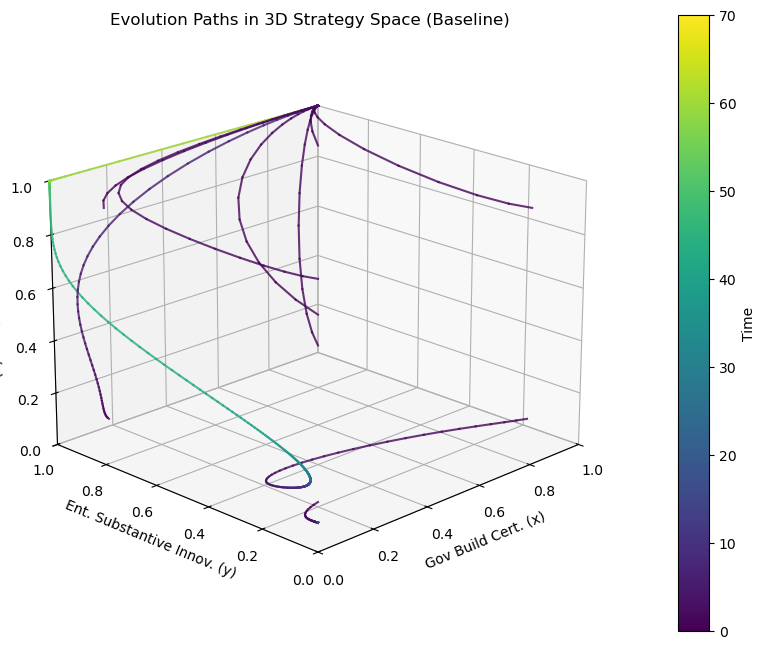

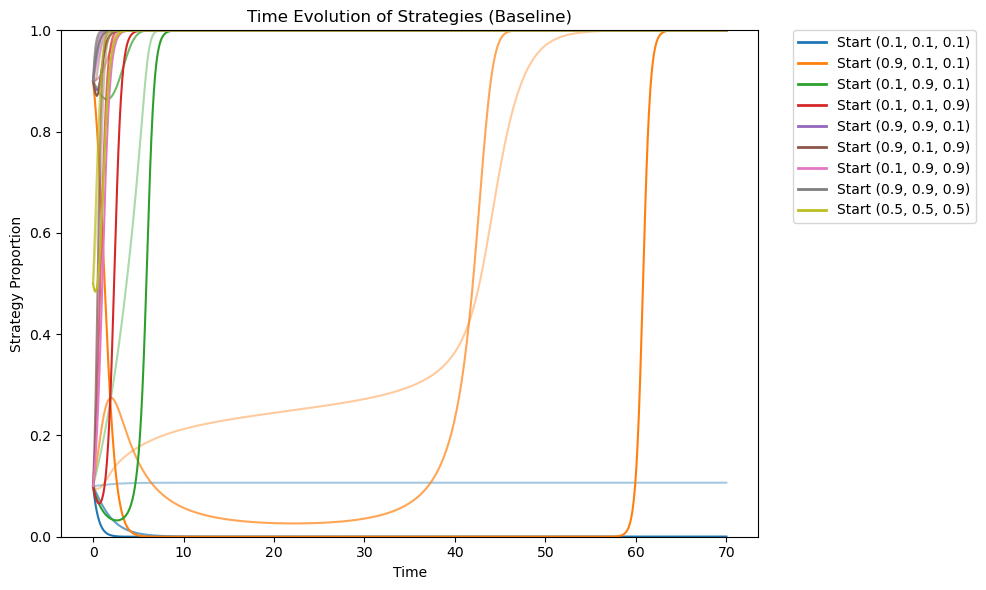

In [10]:
# --- Figure 1: Baseline Scenario ---
print("Simulating Figure 1: Baseline Scenario (E8 stable)")

# 获取基准情景参数
baseline_params = get_parameters('baseline')

# 初始条件 (使用文档中的代表性点)
initial_conditions_fig1 = [
    (0.1, 0.1, 0.1),
    (0.9, 0.1, 0.1),
    (0.1, 0.9, 0.1),
    (0.1, 0.1, 0.9), # 添加一个z较高的初始点
    (0.9, 0.9, 0.1),
    (0.9, 0.1, 0.9),
    (0.1, 0.9, 0.9),
    (0.9, 0.9, 0.9),
    (0.5, 0.5, 0.5)
]

# 时间点 (缩短时间轴，例如到50)
t_fig1 = np.linspace(0, 70, 501) # 501 points from 0 to 50

# --- Figure 1a: 3D Phase Plot with Direction ---
fig1a = plt.figure(figsize=(10, 8))
ax1a = fig1a.add_subplot(111, projection='3d')

# 使用颜色映射表示时间进程
cmap = cm.viridis # 选择一个颜色映射
norm = mcolors.Normalize(vmin=t_fig1.min(), vmax=t_fig1.max()) # 归一化时间到颜色范围

for initial_state in initial_conditions_fig1:
    # 求解ODE
    trajectory = odeint(replicator_dynamics, initial_state, t_fig1, args=(baseline_params,))

    # 确保轨迹点在 [0, 1] 范围内 (数值稳定性处理)
    trajectory = np.clip(trajectory, 0, 1)

    # 绘制轨迹，使用颜色渐变表示时间
    # 将时间序列映射到颜色
    colors = cmap(norm(t_fig1))
    # 绘制分段线条，每段使用对应时间点的颜色
    for i in range(len(t_fig1) - 1):
        ax1a.plot(trajectory[i:i+2, 0], trajectory[i:i+2, 1], trajectory[i:i+2, 2], color=colors[i], alpha=0.8)

    # 可选：在轨迹末端添加一个标记或小箭头（更复杂，这里用颜色渐变代替）
    # ax1a.scatter(trajectory[-1, 0], trajectory[-1, 1], trajectory[-1, 2], color=colors[-1], marker='o', s=20) # 标记终点

ax1a.set_xlabel('Gov Build Cert. (x)')
ax1a.set_ylabel('Ent. Substantive Innov. (y)')
ax1a.set_zlabel('Inv. Long-term (z)')
ax1a.set_title('Evolution Paths in 3D Strategy Space (Baseline)')
ax1a.set_xlim([0, 1])
ax1a.set_ylim([0, 1])
ax1a.set_zlim([0, 1])
ax1a.view_init(elev=20, azim=-135) # 调整视角

# 添加颜色条表示时间
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # 必须设置一个数组，即使是空的
cbar = fig1a.colorbar(sm, ax=ax1a, pad=0.1)
cbar.set_label('Time')

plt.show()


# --- Figure 1b: Time Evolution Trajectories (Shortened Time) ---
fig1b, ax1b = plt.subplots(figsize=(10, 6))

# 绘制每条轨迹的 x, y, z 随时间变化
for i, initial_state in enumerate(initial_conditions_fig1):
    trajectory = odeint(replicator_dynamics, initial_state, t_fig1, args=(baseline_params,))
    trajectory = np.clip(trajectory, 0, 1) # 确保在 [0, 1] 范围内

    # 为每组初始条件使用不同的线条样式或颜色
    line_style = '-' # Solid line
    color = plt.cm.tab10(i / len(initial_conditions_fig1)) # Use a colormap for different initial conditions

    ax1b.plot(t_fig1, trajectory[:, 0], linestyle=line_style, color=color, label=f'Gov (x) Start {initial_state}')
    ax1b.plot(t_fig1, trajectory[:, 1], linestyle=line_style, color=color, alpha=0.7, label=f'Ent (y) Start {initial_state}')
    ax1b.plot(t_fig1, trajectory[:, 2], linestyle=line_style, color=color, alpha=0.4, label=f'Inv (z) Start {initial_state}')



# 为了避免图例过于拥挤，只显示部分代表性轨迹的图例，或者考虑分开绘制
# 这里我们绘制所有，但图例可能需要手动调整或分组
# ax1b.legend(loc='best', bbox_to_anchor=(1, 1)) # 将图例放在外面

ax1b.set_xlabel('Time')
ax1b.set_ylabel('Strategy Proportion')
ax1b.set_title('Time Evolution of Strategies (Baseline)')
ax1b.set_ylim([0, 1])
#ax1b.grid(True)

# 创建一个更简洁的图例，只显示初始点，不区分x,y,z
from matplotlib.lines import Line2D
legend_elements = []
for i, initial_state in enumerate(initial_conditions_fig1):
     color = plt.cm.tab10(i / len(initial_conditions_fig1))
     legend_elements.append(Line2D([0], [0], color=color, lw=2, label=f'Start {initial_state}'))
ax1b.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)


plt.tight_layout() # 调整布局，避免图例遮挡
plt.show()


Simulating Figure 2: Pessimistic Scenario (E1 stable)


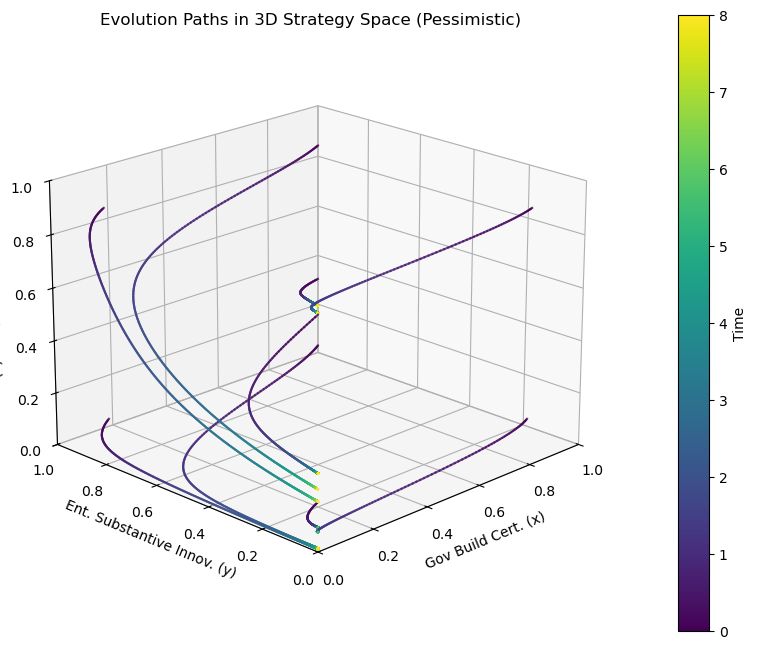

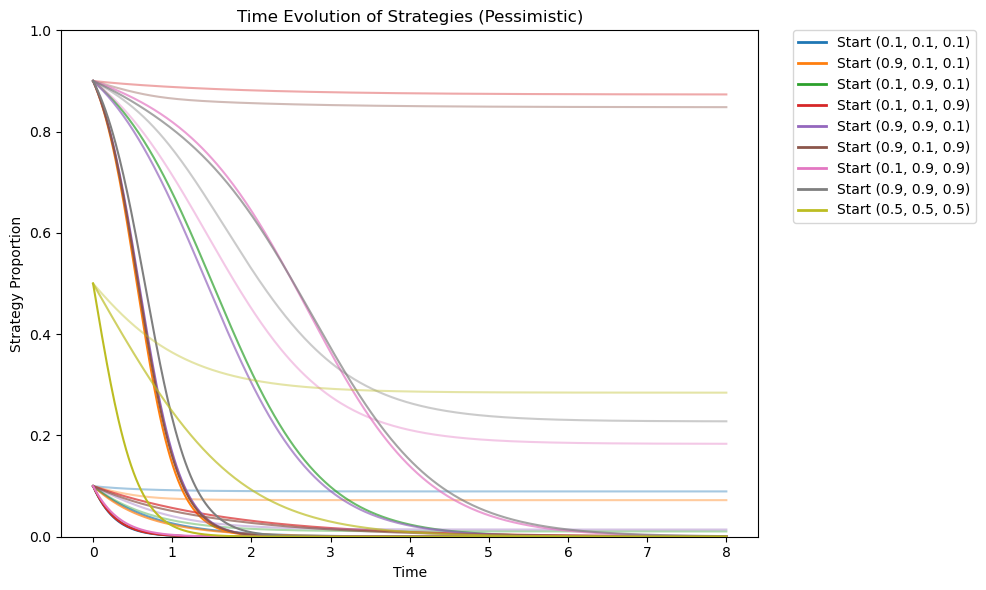

In [14]:
# --- Figure 2: Pessimistic Scenario ---
print("\nSimulating Figure 2: Pessimistic Scenario (E1 stable)")

# 获取悲观情景参数
pessimistic_params = get_parameters('pessimistic')

# 初始条件 (使用文档中的代表性点)
initial_conditions_fig2 = [
    (0.1, 0.1, 0.1),
    (0.9, 0.1, 0.1),
    (0.1, 0.9, 0.1),
    (0.1, 0.1, 0.9),
    (0.9, 0.9, 0.1),
    (0.9, 0.1, 0.9),
    (0.1, 0.9, 0.9),
    (0.9, 0.9, 0.9),
    (0.5, 0.5, 0.5)
]

# 时间点 (缩短时间轴，例如到50)
t_fig2 = np.linspace(0, 8, 501) # 501 points from 0 to 50

# --- Figure 2a: 3D Phase Plot with Direction ---
fig2a = plt.figure(figsize=(10, 8))
ax2a = fig2a.add_subplot(111, projection='3d')

# 使用颜色映射表示时间进程
cmap = cm.viridis
norm = mcolors.Normalize(vmin=t_fig2.min(), vmax=t_fig2.max())

for initial_state in initial_conditions_fig2:
    # 求解ODE
    trajectory = odeint(replicator_dynamics, initial_state, t_fig2, args=(pessimistic_params,))
    trajectory = np.clip(trajectory, 0, 1)

    # 绘制轨迹，使用颜色渐变表示时间
    colors = cmap(norm(t_fig2))
    for i in range(len(t_fig2) - 1):
        ax2a.plot(trajectory[i:i+2, 0], trajectory[i:i+2, 1], trajectory[i:i+2, 2], color=colors[i], alpha=0.8)

ax2a.set_xlabel('Gov Build Cert. (x)')
ax2a.set_ylabel('Ent. Substantive Innov. (y)')
ax2a.set_zlabel('Inv. Long-term (z)')
ax2a.set_title('Evolution Paths in 3D Strategy Space (Pessimistic)')
ax2a.set_xlim([0, 1])
ax2a.set_ylim([0, 1])
ax2a.set_zlim([0, 1])
ax2a.view_init(elev=20, azim=-135)

# 添加颜色条表示时间
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig2a.colorbar(sm, ax=ax2a, pad=0.1)
cbar.set_label('Time')

plt.show()

# --- Figure 2b: Time Evolution Trajectories (Shortened Time) ---
fig2b, ax2b = plt.subplots(figsize=(10, 6))

# 绘制每条轨迹的 x, y, z 随时间变化
for i, initial_state in enumerate(initial_conditions_fig2):
    trajectory = odeint(replicator_dynamics, initial_state, t_fig2, args=(pessimistic_params,))
    trajectory = np.clip(trajectory, 0, 1)

    line_style = '-'
    color = plt.cm.tab10(i / len(initial_conditions_fig2))

    ax2b.plot(t_fig2, trajectory[:, 0], linestyle=line_style, color=color, label=f'Gov (x) Start {initial_state}')
    ax2b.plot(t_fig2, trajectory[:, 1], linestyle=line_style, color=color, alpha=0.7, label=f'Ent (y) Start {initial_state}')
    ax2b.plot(t_fig2, trajectory[:, 2], linestyle=line_style, color=color, alpha=0.4, label=f'Inv (z) Start {initial_state}')

# 创建一个更简洁的图例
legend_elements = []
for i, initial_state in enumerate(initial_conditions_fig2):
     color = plt.cm.tab10(i / len(initial_conditions_fig2))
     legend_elements.append(Line2D([0], [0], color=color, lw=2, label=f'Start {initial_state}'))
ax2b.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)


ax2b.set_xlabel('Time')
ax2b.set_ylabel('Strategy Proportion')
ax2b.set_title('Time Evolution of Strategies (Pessimistic)')
ax2b.set_ylim([0, 1])
#ax2b.grid(True)
plt.tight_layout()
plt.show()



Simulating Figure 3: Sensitivity to Enterprise Certification Net Benefit
Scanning 50 values for B_E...


C:\Users\cyy\AppData\Local\Temp\ipykernel_16156\2599413125.py:31: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  trajectory = odeint(replicator_dynamics, initial_state_sens, t_sens, args=(current_params,))


Scan complete. Plotting Figure 3a.


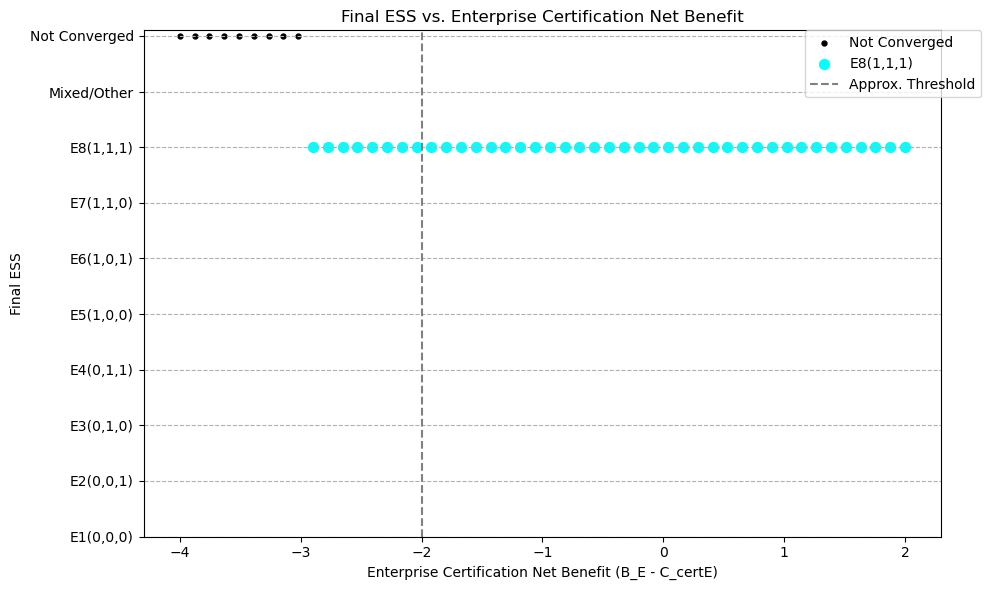

Plotting Figure 3b: Time Evolution for Representative Net Benefits.


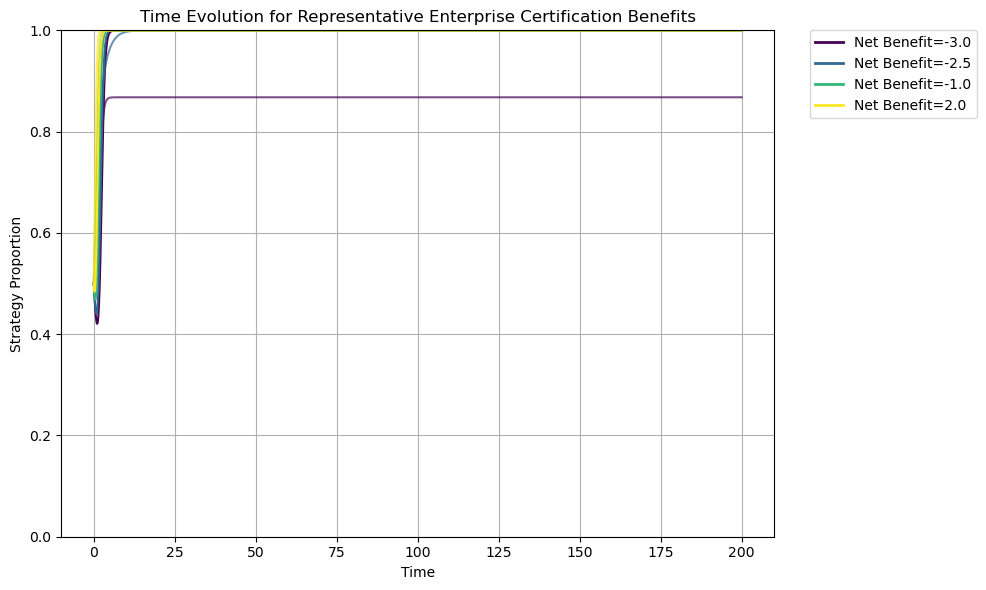

In [33]:
# --- Figure 3: Sensitivity to Enterprise Certification Net Benefit ---
print("\nSimulating Figure 3: Sensitivity to Enterprise Certification Net Benefit")

# 获取基础参数
base_params_sens_BE = get_parameters('sensitivity_BE')

# 扫描的企业认证净收益范围 (B_E - C_certE)
# 我们可以通过改变 B_E 来实现，保持 C_certE 不变
c_certE_fixed = base_params_sens_BE['C_certE']
# 扫描 B_E 的值，使其净收益 B_E - C_certE 覆盖一个范围
be_values = np.linspace(c_certE_fixed - 4.0, c_certE_fixed + 2.0, 50) # 扫描50个点，净收益范围约 [-3, 3]

# 固定的初始条件
initial_state_sens = (0.5, 0.5, 0.5)

# 仿真时间 (需要足够长以确保收敛)
t_sens = np.linspace(0, 200, 2001) # 增加仿真时间以确保收敛

# 存储结果
final_ess_states_be = []
net_benefits_be = []

print(f"Scanning {len(be_values)} values for B_E...")
for be in be_values:
    current_params = base_params_sens_BE.copy()
    current_params['B_E'] = be
    net_benefit = current_params['B_E'] - current_params['C_certE']
    net_benefits_be.append(net_benefit)

    # 求解ODE
    trajectory = odeint(replicator_dynamics, initial_state_sens, t_sens, args=(current_params,))
    trajectory = np.clip(trajectory, 0, 1)

    # 判断最终状态
    final_state = get_final_state(trajectory, epsilon=1e-2, check_last_steps=200) # 稍微放宽epsilon，增加check_last_steps
    final_ess_states_be.append(final_state)

print("Scan complete. Plotting Figure 3a.")

# --- Figure 3a: Final ESS vs. Enterprise Certification Net Benefit ---
fig3a, ax3a = plt.subplots(figsize=(10, 6))

# 将ESS状态映射到数值，以便绘制散点图
ess_to_num = {
    (0, 0, 0): 1, (0, 0, 1): 2, (0, 1, 0): 3, (0, 1, 1): 4,
    (1, 0, 0): 5, (1, 0, 1): 6, (1, 1, 0): 7, (1, 1, 1): 8,
    'Mixed/Other': 9, 'Not Converged': 10 # 给混合/其他和未收敛一个数值
}
num_to_ess_label = {
    1: 'E1(0,0,0)', 2: 'E2(0,0,1)', 3: 'E3(0,1,0)', 4: 'E4(0,1,1)',
    5: 'E5(1,0,0)', 6: 'E6(1,0,1)', 7: 'E7(1,1,0)', 8: 'E8(1,1,1)',
    9: 'Mixed/Other', 10: 'Not Converged'
}

# 绘制散点图，每个点代表一个参数值下的收敛结果
# 使用不同的颜色和标记区分ESS
plotted_ess = set() # 记录已经绘制过的ESS类型，用于图例
for i in range(len(be_values)):
    ess_state = final_ess_states_be[i]
    net_benefit = net_benefits_be[i]
    color, marker = get_ess_color_marker(ess_state)
    label = num_to_ess_label.get(ess_to_num.get(ess_state), 'Unknown') # 获取图例标签

    # 只在第一次遇到某个ESS类型时添加label，用于生成图例
    if ess_state not in plotted_ess:
        ax3a.scatter(net_benefit, ess_to_num.get(ess_state, 10), color=color, marker=marker, label=label, s=50)
        plotted_ess.add(ess_state)
    else:
        ax3a.scatter(net_benefit, ess_to_num.get(ess_state, 10), color=color, marker=marker, s=50)

ax3a.set_xlabel('Enterprise Certification Net Benefit (B_E - C_certE)')
ax3a.set_ylabel('Final ESS')
ax3a.set_title('Final ESS vs. Enterprise Certification Net Benefit')

# 设置Y轴刻度标签为ESS名称
ax3a.set_yticks(list(num_to_ess_label.keys()))
ax3a.set_yticklabels(list(num_to_ess_label.values()))
ax3a.grid(True, axis='y', linestyle='--')

# 添加理论阈值线 (如果已知且简单的话)
# 例如，E8稳定的条件之一是 B_E - C_certE + R_H - R_O > 0
# 阈值大约在 B_E - C_certE = R_O - R_H
# 在 base_params_sens_BE 中: R_O - R_H = 2.0 - 5.0 = -3.0
# 理论上 E8 应该在净收益 > -3.0 时可能稳定 (如果其他条件满足)
# 另一个重要条件是企业选择实质创新的收益 > 策略性创新收益: x(B_E-C_certE) + zR_H + (1-z)R_L - R_O > 0
# 在初始点 (0.5, 0.5, 0.5) 处，条件变为 0.5*(B_E-C_certE) + 0.5*R_H + 0.5*R_L - R_O > 0
# 0.5*(B_E-C_certE) + 0.5*5.0 + 0.5*1.0 - 2.0 > 0
# 0.5*(B_E-C_certE) + 2.5 + 0.5 - 2.0 > 0
# 0.5*(B_E-C_certE) + 1.0 > 0
# B_E-C_certE > -2.0
# 在净收益约为 -2.0 附近可能发生跃迁
ax3a.axvline(-2.0, color='gray', linestyle='--', label='Approx. Threshold')


ax3a.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.savefig("fig3a.png")
plt.show()

# --- Figure 3b: Time Evolution for Representative Net Benefits ---
print("Plotting Figure 3b: Time Evolution for Representative Net Benefits.")

# 选择几个代表性的净收益值
# 根据图3a的观察，选择低、中、高三个值
# 例如：-2.5 (E1), -1.0 (可能混合/其他), 2.0 (E8)
representative_net_benefits = [-3.0,-2.5, -1.0, 2.0]
representative_be_values = [nb + c_certE_fixed for nb in representative_net_benefits]

fig3b, ax3b = plt.subplots(figsize=(10, 6))

# 绘制每组代表性参数下的 x, y, z 随时间变化
for i, be in enumerate(representative_be_values):
    current_params = base_params_sens_BE.copy()
    current_params['B_E'] = be
    net_benefit = current_params['B_E'] - current_params['C_certE']

    trajectory = odeint(replicator_dynamics, initial_state_sens, t_sens, args=(current_params,))
    trajectory = np.clip(trajectory, 0, 1)

    line_style = '-'
    color = plt.cm.viridis(i / (len(representative_be_values) - 1)) # 使用颜色映射区分不同参数值

    ax3b.plot(t_sens, trajectory[:, 0], linestyle=line_style, color=color, label=f'Gov (x) Net Benefit={net_benefit:.1f}')
    ax3b.plot(t_sens, trajectory[:, 1], linestyle=line_style, color=color, alpha=0.7, label=f'Ent (y) Net Benefit={net_benefit:.1f}')
    ax3b.plot(t_sens, trajectory[:, 2], linestyle=line_style, color=color, alpha=0.4, label=f'Inv (z) Net Benefit={net_benefit:.1f}')

# 创建一个更简洁的图例
legend_elements = []
for i, net_benefit in enumerate(representative_net_benefits):
     color = plt.cm.viridis(i / (len(representative_net_benefits) - 1))
     legend_elements.append(Line2D([0], [0], color=color, lw=2, label=f'Net Benefit={net_benefit:.1f}'))
ax3b.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)


ax3b.set_xlabel('Time')
ax3b.set_ylabel('Strategy Proportion')
ax3b.set_title('Time Evolution for Representative Enterprise Certification Benefits')
ax3b.set_ylim([0, 1])
ax3b.grid(True)
plt.tight_layout()
plt.show()



Simulating Figure 4: Sensitivity to Investor Long-term Net Benefit
Scanning 50 values for P_H...
Scan complete. Plotting Figure 4a.


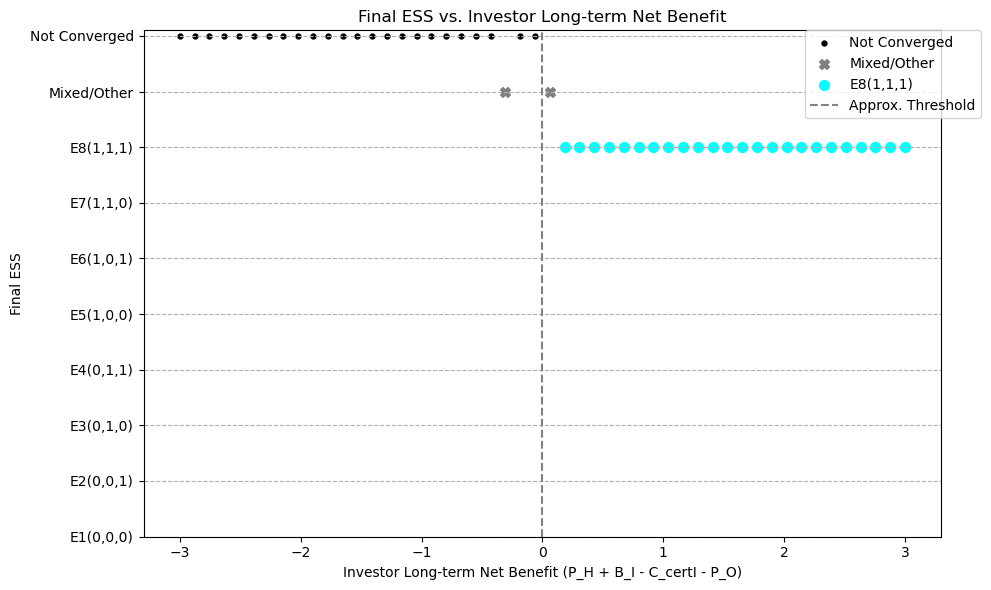

Plotting Figure 4b: Time Evolution for Representative Net Benefits.


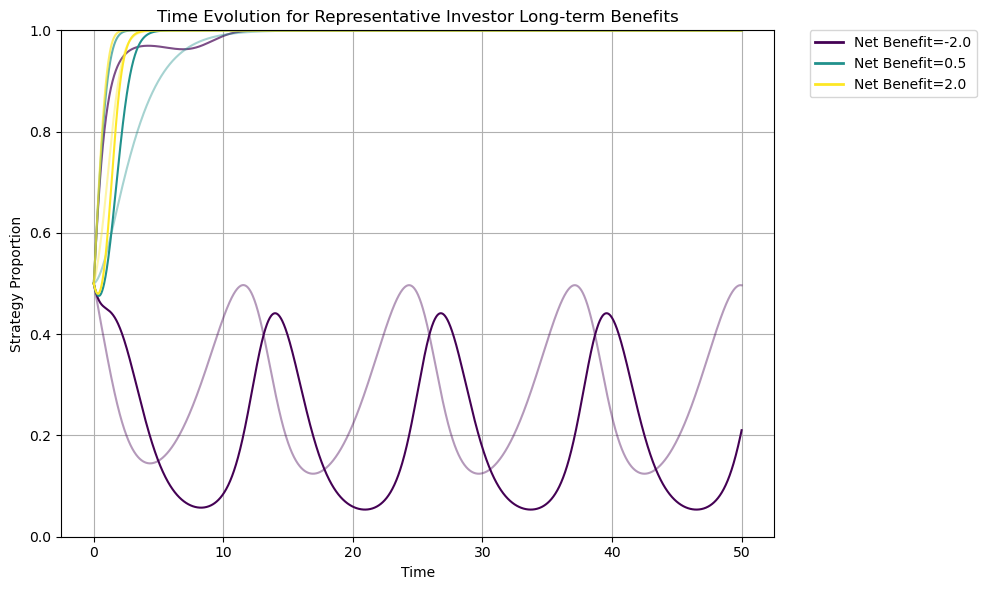

In [34]:
# --- Figure 4: Sensitivity to Investor Long-term Net Benefit ---
print("\nSimulating Figure 4: Sensitivity to Investor Long-term Net Benefit")

# 获取基础参数
base_params_sens_PI = get_parameters('sensitivity_PI')

# 扫描的投资机构长期投资净收益范围 (P_H + B_I - C_certI - P_O)
# 我们可以通过改变 P_H 来实现，保持其他参数不变
b_i_fixed = base_params_sens_PI['B_I']
c_certi_fixed = base_params_sens_PI['C_certI']
p_o_fixed = base_params_sens_PI['P_O']
# 扫描 P_H 的值，使其净收益覆盖一个范围
ph_values = np.linspace(p_o_fixed + c_certi_fixed - b_i_fixed - 3.0, p_o_fixed + c_certi_fixed - b_i_fixed + 3.0, 50) # 扫描50个点，净收益范围约 [-3, 3]

# 固定的初始条件
initial_state_sens = (0.5, 0.5, 0.5)

# 仿真时间
t_sens = np.linspace(0, 50, 2001)

# 存储结果
final_ess_states_pi = []
net_benefits_pi = []

print(f"Scanning {len(ph_values)} values for P_H...")
for ph in ph_values:
    current_params = base_params_sens_PI.copy()
    current_params['P_H'] = ph
    net_benefit = current_params['P_H'] + current_params['B_I'] - current_params['C_certI'] - current_params['P_O']
    net_benefits_pi.append(net_benefit)

    # 求解ODE
    trajectory = odeint(replicator_dynamics, initial_state_sens, t_sens, args=(current_params,))
    trajectory = np.clip(trajectory, 0, 1)

    # 判断最终状态
    final_state = get_final_state(trajectory, epsilon=1e-2, check_last_steps=200)
    final_ess_states_pi.append(final_state)

print("Scan complete. Plotting Figure 4a.")

# --- Figure 4a: Final ESS vs. Investor Long-term Net Benefit ---
fig4a, ax4a = plt.subplots(figsize=(10, 6))

# 绘制散点图
plotted_ess = set()
for i in range(len(ph_values)):
    ess_state = final_ess_states_pi[i]
    net_benefit = net_benefits_pi[i]
    color, marker = get_ess_color_marker(ess_state)
    label = num_to_ess_label.get(ess_to_num.get(ess_state), 'Unknown')

    if ess_state not in plotted_ess:
        ax4a.scatter(net_benefit, ess_to_num.get(ess_state, 10), color=color, marker=marker, label=label, s=50)
        plotted_ess.add(ess_state)
    else:
        ax4a.scatter(net_benefit, ess_to_num.get(ess_state, 10), color=color, marker=marker, s=50)

ax4a.set_xlabel('Investor Long-term Net Benefit (P_H + B_I - C_certI - P_O)')
ax4a.set_ylabel('Final ESS')
ax4a.set_title('Final ESS vs. Investor Long-term Net Benefit')

# 设置Y轴刻度标签
ax4a.set_yticks(list(num_to_ess_label.keys()))
ax4a.set_yticklabels(list(num_to_ess_label.values()))
ax4a.grid(True, axis='y', linestyle='--')

# 添加理论阈值线 (如果已知且简单的话)
# E8稳定的条件之一是 P_H + B_I - C_certI - P_O > 0
# 阈值大约在 P_H + B_I - C_certI - P_O = 0
ax4a.axvline(0.0, color='gray', linestyle='--', label='Approx. Threshold')


ax4a.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

# --- Figure 4b: Time Evolution for Representative Net Benefits ---
print("Plotting Figure 4b: Time Evolution for Representative Net Benefits.")

# 选择几个代表性的净收益值
# 根据图4a的观察，选择低、中、高三个值
# 例如：-2.0 (E1), 0.5 (可能混合/其他), 2.0 (E8)
representative_net_benefits_pi = [-2.0, 0.5, 2.0]
representative_ph_values = [nb + p_o_fixed + c_certi_fixed - b_i_fixed for nb in representative_net_benefits_pi]

fig4b, ax4b = plt.subplots(figsize=(10, 6))

# 绘制每组代表性参数下的 x, y, z 随时间变化
for i, ph in enumerate(representative_ph_values):
    current_params = base_params_sens_PI.copy()
    current_params['P_H'] = ph
    net_benefit = current_params['P_H'] + current_params['B_I'] - current_params['C_certI'] - current_params['P_O']

    trajectory = odeint(replicator_dynamics, initial_state_sens, t_sens, args=(current_params,))
    trajectory = np.clip(trajectory, 0, 1)

    line_style = '-'
    color = plt.cm.viridis(i / (len(representative_ph_values) - 1))

    ax4b.plot(t_sens, trajectory[:, 0], linestyle=line_style, color=color, label=f'Gov (x) Net Benefit={net_benefit:.1f}')
    ax4b.plot(t_sens, trajectory[:, 1], linestyle=line_style, color=color, alpha=0.7, label=f'Ent (y) Net Benefit={net_benefit:.1f}')
    ax4b.plot(t_sens, trajectory[:, 2], linestyle=line_style, color=color, alpha=0.4, label=f'Inv (z) Net Benefit={net_benefit:.1f}')

# 创建一个更简洁的图例
legend_elements = []
for i, net_benefit in enumerate(representative_net_benefits_pi):
     color = plt.cm.viridis(i / (len(representative_net_benefits_pi) - 1))
     legend_elements.append(Line2D([0], [0], color=color, lw=2, label=f'Net Benefit={net_benefit:.1f}'))
ax4b.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)


ax4b.set_xlabel('Time')
ax4b.set_ylabel('Strategy Proportion')
ax4b.set_title('Time Evolution for Representative Investor Long-term Benefits')
ax4b.set_ylim([0, 1])
ax4b.grid(True)
plt.tight_layout()
plt.show()



Simulating Figure 5: Two-Parameter Interaction Analysis
Scanning 30x30 = 900 parameter combinations...


C:\Users\cyy\AppData\Local\Temp\ipykernel_16156\1431131516.py:37: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  trajectory = odeint(replicator_dynamics, initial_state_sens, t_sens, args=(current_params,))


Scan complete. Plotting Figure 5.


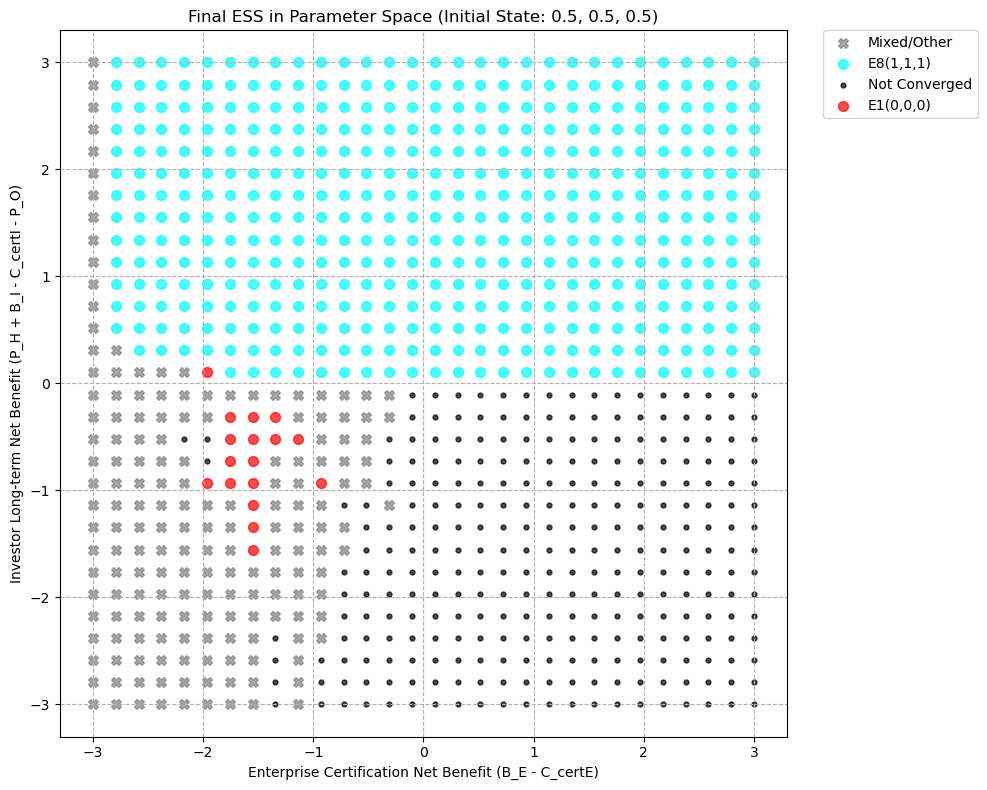

In [35]:
# --- Figure 5: Two-Parameter Interaction Analysis ---
print("\nSimulating Figure 5: Two-Parameter Interaction Analysis")

# 获取基础参数 (使用基准参数作为起点)
base_params_interaction = get_parameters('baseline')

# 扫描的企业认证净收益范围 (B_E - C_certE)
c_certE_fixed_int = base_params_interaction['C_certE']
be_range = np.linspace(c_certE_fixed_int - 3.0, c_certE_fixed_int + 3.0, 30) # 增加扫描点到 30x30 = 900点

# 扫描的投资机构长期投资净收益范围 (P_H + B_I - C_certI - P_O)
b_i_fixed_int = base_params_interaction['B_I']
c_certi_fixed_int = base_params_interaction['C_certI']
p_o_fixed_int = base_params_interaction['P_O']
ph_range = np.linspace(p_o_fixed_int + c_certi_fixed_int - b_i_fixed_int - 3.0, p_o_fixed_int + c_certi_fixed_int - b_i_fixed_int + 3.0, 30) # 增加扫描点到 30x30 = 900点

# 固定的初始条件
initial_state_sens = (0.5, 0.5, 0.5)

# 仿真时间
t_sens = np.linspace(0, 200, 2001)

# 存储结果
interaction_results = [] # List of (net_benefit_be, net_benefit_pi, final_ess)

print(f"Scanning {len(be_range)}x{len(ph_range)} = {len(be_range)*len(ph_range)} parameter combinations...")
for be in be_range:
    for ph in ph_range:
        current_params = base_params_interaction.copy()
        current_params['B_E'] = be
        current_params['P_H'] = ph

        net_benefit_be = current_params['B_E'] - current_params['C_certE']
        net_benefit_pi = current_params['P_H'] + current_params['B_I'] - current_params['C_certI'] - current_params['P_O']

        # 求解ODE
        trajectory = odeint(replicator_dynamics, initial_state_sens, t_sens, args=(current_params,))
        trajectory = np.clip(trajectory, 0, 1)

        # 判断最终状态
        final_state = get_final_state(trajectory, epsilon=1e-2, check_last_steps=200)
        interaction_results.append((net_benefit_be, net_benefit_pi, final_state))

print("Scan complete. Plotting Figure 5.")

# --- Figure 5: Final ESS in Parameter Space ---
fig5, ax5 = plt.subplots(figsize=(10, 8))

# 绘制散点图，每个点代表一个参数组合下的收敛结果
# 使用不同的颜色和标记区分ESS
plotted_ess = set()
for res in interaction_results:
    net_benefit_be, net_benefit_pi, ess_state = res
    color, marker = get_ess_color_marker(ess_state)
    label = num_to_ess_label.get(ess_to_num.get(ess_state), 'Unknown')

    if ess_state not in plotted_ess:
        ax5.scatter(net_benefit_be, net_benefit_pi, color=color, marker=marker, label=label, s=50, alpha=0.7) # 增加透明度
        plotted_ess.add(ess_state)
    else:
        ax5.scatter(net_benefit_be, net_benefit_pi, color=color, marker=marker, s=50, alpha=0.7)

ax5.set_xlabel('Enterprise Certification Net Benefit (B_E - C_certE)')
ax5.set_ylabel('Investor Long-term Net Benefit (P_H + B_I - C_certI - P_O)')
ax5.set_title('Final ESS in Parameter Space (Initial State: 0.5, 0.5, 0.5)')
ax5.grid(True, linestyle='--')
ax5.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.savefig("fig5.png")
plt.show()



Simulating Figure 6: Basin of Attraction Analysis (Colored by Final ESS)


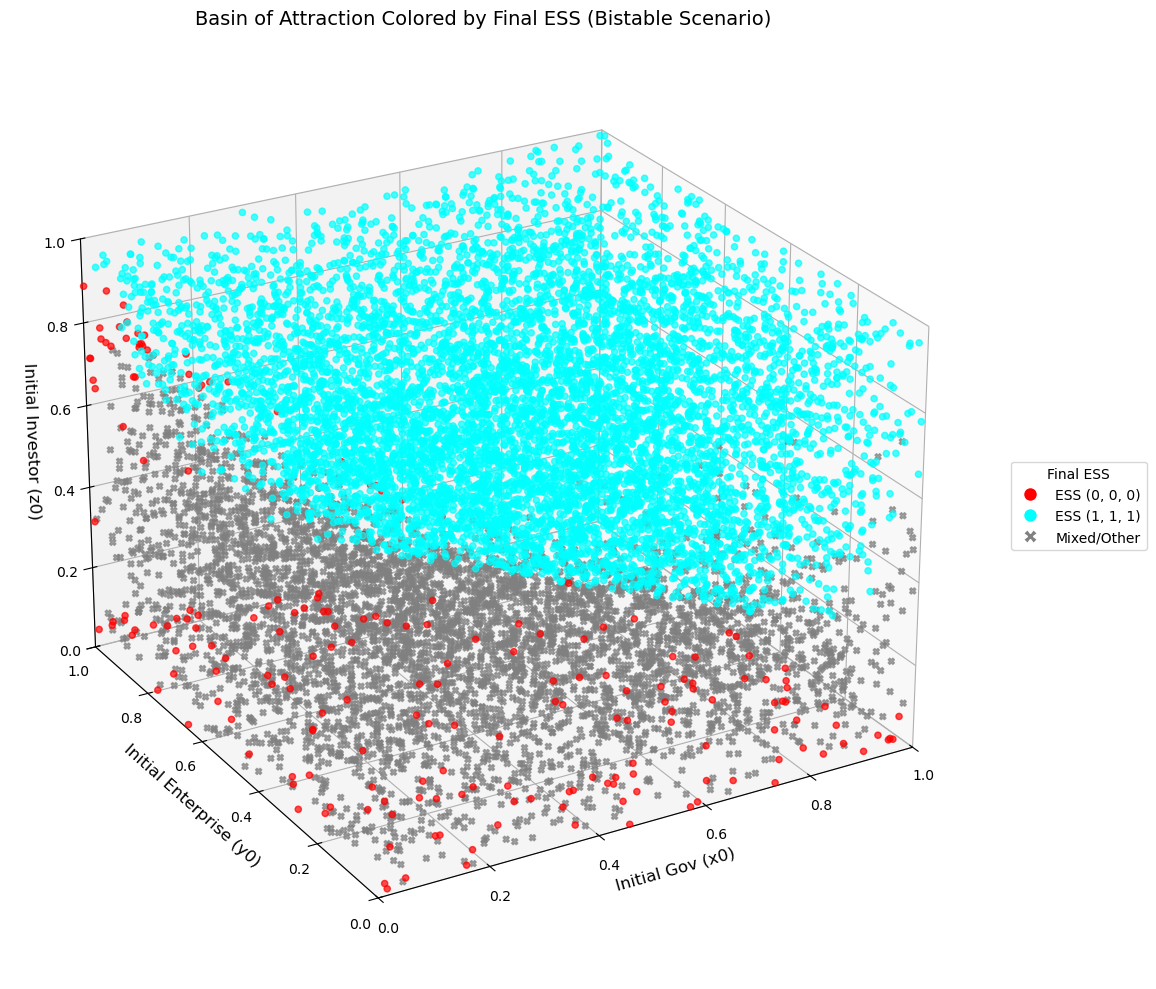

In [29]:
# --- Figure 6: Basin of Attraction Analysis (Corrected Version) ---
print("\nSimulating Figure 6: Basin of Attraction Analysis (Colored by Final ESS)")

# 获取双稳态情景参数
bistable_params = get_parameters('bistable')

# 生成大量随机初始条件（减少点数以提高速度，但保持统计意义）
num_random_points = 12000  # 适当减少点数以避免过度拥挤
random_initial_conditions = np.random.rand(num_random_points, 3)

# 仿真时间（确保足够长以收敛）
t_basin = np.linspace(0, 300, 3001)

# 存储结果：初始点 + 最终ESS
basin_results = []
for initial_state in random_initial_conditions:
    trajectory = odeint(replicator_dynamics, initial_state, t_basin, args=(bistable_params,))
    trajectory = np.clip(trajectory, 0, 1)
    final_state = get_final_state(trajectory, epsilon=1e-2)
    basin_results.append((*initial_state, final_state))  # (x0, y0, z0, final_ess)

# --- 绘制3D吸引域图 ---
fig6 = plt.figure(figsize=(12, 10))
ax6 = fig6.add_subplot(111, projection='3d')

# 按最终ESS分类初始点
ess_to_points = {
    (0, 0, 0): [], (0, 0, 1): [], (0, 1, 0): [], (0, 1, 1): [],
    (1, 0, 0): [], (1, 0, 1): [], (1, 1, 0): [], (1, 1, 1): [],
    'Mixed/Other': [], 'Not Converged': []
}

for x0, y0, z0, final_ess in basin_results:
    ess_to_points[final_ess].append((x0, y0, z0))

# 为每种ESS绘制散点（使用预定义颜色和标记）
for ess_state, points in ess_to_points.items():
    if points:  # 仅绘制实际存在的ESS类型
        points_array = np.array(points)
        color, marker = get_ess_color_marker(ess_state)
        label = f'ESS {ess_state}' if isinstance(ess_state, tuple) else ess_state
        ax6.scatter(
            points_array[:, 0], points_array[:, 1], points_array[:, 2],
            color=color, marker=marker, s=20, alpha=0.7, label=label
        )

# 设置坐标轴和标题
ax6.set_xlabel('Initial Gov (x0)', fontsize=12)
ax6.set_ylabel('Initial Enterprise (y0)', fontsize=12)
ax6.set_zlabel('Initial Investor (z0)', fontsize=12)
ax6.set_title('Basin of Attraction Colored by Final ESS (Bistable Scenario)', fontsize=14)
ax6.set_xlim([0, 1])
ax6.set_ylim([0, 1])
ax6.set_zlim([0, 1])
ax6.view_init(elev=25, azim=-120)  # 调整视角

# 添加专业图例
legend_elements = []
for ess_state in ess_to_points.keys():
    if ess_to_points[ess_state]:  # 仅包含实际出现的ESS
        color, marker = get_ess_color_marker(ess_state)
        label = f'ESS {ess_state}' if isinstance(ess_state, tuple) else ess_state
        legend_elements.append(
            Line2D([0], [0], marker=marker, color='w', label=label,
                   markerfacecolor=color, markersize=10)
        )

ax6.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    title="Final ESS",
    fontsize=10
)

plt.tight_layout()
plt.show()
